# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В моем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Мне нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Доп. условия:

- Для оценки качества моделей применяйте метрику RMSE;
- Значение метрики RMSE должно быть меньше 2500;
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга

## Загрузка данных

In [69]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder 

In [25]:
path1 = '/datasets/autos.csv'

path2 = 'autos.csv'

if os.path.exists(path1):
    auto_train = pd.read_csv(path1)
    
elif os.path.exists(path2):
    auto_train = pd.read_csv(path2)

else:
    print('Something is wrong')

In [26]:
display(auto_train.head(10))
display(auto_train.info())
display(auto_train.describe())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Легенда:**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- Price — цена (евро)

**Общий взгляд на данные:**

- в данных присутствуют пропуски
- в колонке месяца нет некорректных значений
- в колонке год есть некорректные значения (нереалистичные значения мин. и макс.)
- в колонке цены есть 0, это надо проверить, скорее всего данные некорректны
- в колонке мощности л.с. есть некорректные значения (мин. и макс. выглядят нереалистично)
- колонка с фото не нужна - она нулевая
- колонки с датами некорректный тип данных, но данной задачи это роль не сыграет
- в остальных колонках тип данных корректен

### Предобработка данных

#### Заполнение пропусков

Начнем с пропусков. Рассмотрим в каких колонках есть пропуски и оценим их долю от общего числа строк:

In [27]:
print(f'VehicleType: {1 - 316879/354369:.2%}')
print(f'Gearbox: {1 - 334536/354369:.2%}')
print(f'Model: {1 - 334664/354369:.2%}')
print(f'FuelType: {1 - 321474/354369:.2%}')
print(f'NotRepaired: {1 - 283215/354369:.2%}')

VehicleType: 10.58%
Gearbox: 5.60%
Model: 5.56%
FuelType: 9.28%
NotRepaired: 20.08%


У VehicleType, FuelType и NotRepaired значительное количество пропусков. Очень жаль, я хотела просто грохнуть порченные данные. Беда в том, что это категориальные значения и восстановить тип кузова, тип топлива и тип коробки пердач возможно (чисто гипотетически) по модели и марки автомобиля. Но самую значительную часть пропущенных данных - было в починке или нет, никак не восстановить. Предлагаю в данной колонке оставить "отсутствие данных о ремонте" как третий категориальный признак для этой колонки.

Чтобы понять, могу ли я подтянуть недостающие значения запчастей автомобила, я попробую взять колонки с этими запчастями, молями и брендами, удалить дубликаты, ранжировать и посмотреть, если я увижe что одному и тому же сочетанию бренд+модель соответствует всегда одни и те же детали, то я смогу самостоятельно заполнить часть пропусков в данных.

In [28]:
gears = auto_train[['Brand','Model','VehicleType','Gearbox','FuelType']]
gears = gears.drop_duplicates().sort_values(by = ['Brand','Model']).dropna()
print(gears.head(20))

             Brand Model VehicleType Gearbox  FuelType
11267   alfa_romeo   145       small  manual    petrol
15254   alfa_romeo   145       sedan  manual    petrol
73386   alfa_romeo   145       coupe  manual    petrol
281893  alfa_romeo   145       other  manual    petrol
138     alfa_romeo   147       sedan  manual  gasoline
474     alfa_romeo   147       sedan  manual    petrol
2100    alfa_romeo   147       small  manual    petrol
4508    alfa_romeo   147       small  manual  gasoline
24659   alfa_romeo   147       sedan  manual       lpg
30100   alfa_romeo   147       wagon  manual  gasoline
30175   alfa_romeo   147       coupe  manual    petrol
31162   alfa_romeo   147       sedan    auto    petrol
33171   alfa_romeo   147       small    auto    petrol
48809   alfa_romeo   147       coupe    auto    petrol
55333   alfa_romeo   147       coupe  manual  gasoline
69445   alfa_romeo   147       small  manual       lpg
81667   alfa_romeo   147       other    auto    petrol
91590   al

Уже на 147 модели первого бренда понятно, что однозначно назвать деталь основываясь на информации о других параметрах машины нельзя. В таком случае заполню все пропуски "unknown", пусть это будет новое категориальное значение. 

In [29]:
auto_train[['Brand','Model','VehicleType','Gearbox','FuelType','NotRepaired']] = auto_train[['Brand','Model','VehicleType','Gearbox','FuelType','NotRepaired']].fillna('unknown')
display(auto_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              354369 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

Пропусков больше нет, двигаемся дальше

#### Работа с некорректными значениями

При предварительном обзоре данных видно, что:

- в колонке год есть некорректные значения (нереалистичные значения мин. и макс.)
- в колонке цены есть 0, это надо проверить, скорее всего данные некорректны
- в колонке мощности л.с. есть некорректные значения (мин. и макс. выглядят нереалистично)

Начнем с 1 пункта. Рассмотрим какие года есть в нас в датасете.

**Год регистрации**

Посмотрим, какие года есть в выборке

In [30]:
print(auto_train[['RegistrationYear']].groupby('RegistrationYear').count())

Empty DataFrame
Columns: []
Index: [1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500, 1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, ...]

[151 rows x 0 columns]


Рассмотрим, как выглядят данные для самых маленьких годов регистрации

In [31]:
display(auto_train.sort_values(by='RegistrationYear').head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
244092,2016-03-26 19:52:56,2000,unknown,1000,unknown,0,unknown,5000,0,unknown,sonstige_autos,unknown,2016-03-26 00:00:00,0,31188,2016-04-02 12:46:25
91869,2016-03-11 14:45:24,400,unknown,1000,unknown,0,unknown,5000,0,unknown,sonstige_autos,unknown,2016-03-11 00:00:00,0,48683,2016-03-12 18:45:19
143621,2016-03-17 23:40:11,550,unknown,1000,unknown,1000,golf,5000,6,petrol,volkswagen,unknown,2016-03-17 00:00:00,0,91732,2016-03-26 05:18:19
55605,2016-03-10 19:50:17,500,unknown,1000,unknown,0,unknown,5000,0,unknown,citroen,yes,2016-03-10 00:00:00,0,24811,2016-04-06 03:45:53
164397,2016-03-29 17:49:10,0,unknown,1000,unknown,0,transporter,5000,1,unknown,volkswagen,unknown,2016-03-29 00:00:00,0,29351,2016-04-06 03:45:14


In [32]:
display(auto_train[(auto_train['RegistrationYear'] >= 1800) & (auto_train['RegistrationYear'] <= 1942)].sort_values(by='RegistrationYear',ascending=False))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
323913,2016-03-07 13:51:17,0,suv,1942,manual,0,other,100000,0,gasoline,jeep,unknown,2016-03-07 00:00:00,0,82272,2016-03-17 17:15:26
230679,2016-04-01 12:37:37,7500,suv,1942,manual,72,other,100000,2,gasoline,jeep,no,2016-04-01 00:00:00,0,63925,2016-04-05 06:17:31
88033,2016-03-29 15:37:22,6999,suv,1942,manual,72,other,150000,2,gasoline,jeep,no,2016-03-29 00:00:00,0,63925,2016-04-06 01:15:33
188344,2016-03-15 10:50:59,10700,suv,1941,unknown,0,other,150000,0,petrol,jeep,unknown,2016-03-15 00:00:00,0,70806,2016-04-07 07:17:15
16635,2016-03-09 10:54:11,9500,suv,1941,manual,57,unknown,40000,1,petrol,sonstige_autos,no,2016-03-09 00:00:00,0,59557,2016-03-12 21:16:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195855,2016-03-28 23:40:10,1,unknown,1800,unknown,0,zafira,5000,0,unknown,opel,unknown,2016-03-28 00:00:00,0,50171,2016-04-05 03:44:47
218241,2016-03-16 12:46:55,7999,unknown,1800,unknown,290,golf,5000,6,unknown,volkswagen,unknown,2016-03-16 00:00:00,0,15827,2016-03-29 20:47:40
34332,2016-04-01 06:02:10,450,unknown,1800,unknown,1800,unknown,5000,2,unknown,mitsubishi,no,2016-04-01 00:00:00,0,63322,2016-04-01 09:42:30
139360,2016-04-02 16:56:39,450,unknown,1800,unknown,1800,unknown,5000,2,unknown,mitsubishi,no,2016-04-02 00:00:00,0,63322,2016-04-04 14:46:21


Так, ну это явно все порченные данные. Джип 1942 года, который ни разу не был в ремонте? Ну да конечно.
Давайте подумаем какой кусок данных надо отсечь. Для этого построим график.

AxesSubplot(0.125,0.125;0.775x0.755)


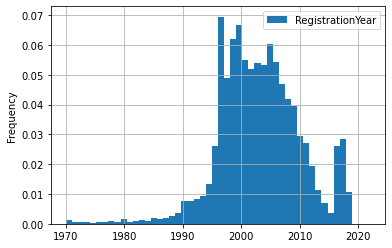

In [33]:
print(auto_train['RegistrationYear'].plot(kind='hist', 
    bins=50, 
    range=(1970, 2022),
    grid = True, 
    legend=True,
    density=True))

Большая часть данных приходится на автомобили свыше 1990 года регистрации. Думаю, можно отрезать все строки, где год регистрации меньше 1990. Верхняя планка - год выгрузки анкет - 2016 год.

In [34]:
auto_train_cut1 = auto_train[(auto_train['RegistrationYear'] >=1990)&(auto_train['RegistrationYear'] <=2016)]
print(f'Отрезано {1 - len(auto_train_cut1) / len(auto_train):.2%} данных')
print('Текущее количество данных:',len(auto_train_cut1))

Отрезано 6.83% данных
Текущее количество данных: 330170


**Цена автомобилей**


Далее рассмотрим распределение цен на автомобили, чтобы определить минимальную границу и избавиться на 0 в ценах

AxesSubplot(0.125,0.125;0.775x0.755)


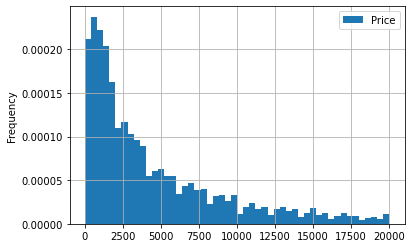

In [35]:
print(auto_train['Price'].plot(kind='hist', 
    bins=50, 
    grid = True, 
    legend=True,
    density=True))

Распределение выглядит логичным, большинство автомобилей стоят до 5000 евро, далее размер цены обратно пропорционален количеству автомобилей. Рассмотрим укрупненно нижнюю границу менее 2500 евро, чтобы понять нижнюю границу цены.

AxesSubplot(0.125,0.125;0.775x0.755)


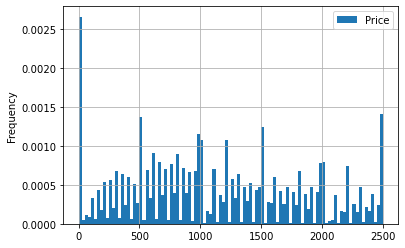

In [36]:
print(auto_train_cut1['Price'].plot(kind='hist', 
    bins=100,
    range = (0,2500),
    grid = True, 
    legend=True,
    density=True))

Квантиль 25% цены это 1050 евро, поэтому чтобы не отрезать четверть данных возьмем границу меньше 1050. Предлагаю остановиться на 500 евро.

In [37]:
auto_train_cut2 = auto_train_cut1[auto_train_cut1['Price'] >=500]
print(f'Отрезано {1 - len(auto_train_cut2) / len(auto_train_cut1):.2%} данных')
print('Текущее количество данных:',len(auto_train_cut2))

Отрезано 10.04% данных
Текущее количество данных: 297008


**Мощность двигателя**

В данной колонке также обнаружены некорректные значения. Гугл говорит, что самое низкое (адекватное для размеров нормального автомобиля) значение мощности 25 л.с - предлагаю это значение оставить нижней границей. Самая большая мощность автомобиля в данный момент около 1600 л.с. Давайте оставим это значение для верхней границы. Возможно, в нащей выборке есть спорт-кары.

In [38]:
auto_train_cut3 = auto_train_cut2[(auto_train_cut2['Power'] >= 25) & (auto_train_cut2['Power'] <= 1600)]
print(f'Отрезано {1 - len(auto_train_cut3) / len(auto_train_cut2):.2%} данных')
print('Текущее количество данных:',len(auto_train_cut3))

Отрезано 8.18% данных
Текущее количество данных: 272707


Пояснение: для предобработки данных я каждый раз использую новую переменную, чтобы в случае чего можно было откатиться к одной из версий датасета, плюс у меня в прошлых проектах часто ломался код из-за того, что я в предобработке перезаписывала  переменную, куда загружался исходный датасет

#### Формируем обучающий датасет

Удалим дубликаты, перезапишем индексы и выкинем нулевую колонку с количеством фото, а также данные о дате скачивания анкеты, месяц регистрации автомобиля, дата создания анкеты, почтовый индекс и дата последней активности, потому что с точки зрения здравого смысла эти данные не влияют на цену автомобиля. 

Хотя если углубиться, то дата создания анкеты косвенно влияет на цену, потому что по дате размещения можно учесть инфляцию и валютные колебания и, например, дисконтировать стоимость автомобиля. Кроме того, в определенные моменты времени из-за каких-либо нерыночных факторов цены на автомобили могут сильно расти или падать. Если мы знаем, в какие периоды времени происходили такие нерыночные росты/падения цены, то с помощью даты размещения и года регистрации автомобиля мы можем понять, в какую сторону необходимо скорректировать цену автомобиля. Но это требует серьезных временных затрат и, полагаю, не требуется в рамках данного проекта. 

In [39]:
auto = auto_train_cut3.drop(['NumberOfPictures','DateCrawled','RegistrationMonth','DateCreated','PostalCode','LastSeen'],axis = 1).drop_duplicates().reset_index(drop=True)

## Обучение моделей

Подготовка обучающих данных

Используем следующие модели для обучения и сравним их точность: 

1. линейная регрессия, 
2. дерево решений, 
3. случайный лес
4. модель градиентного бустинга из библиотеки LightGBM

Далее под этими цифрами я буду нумеровать переменные каждой модели

Далее закодируем категориальные переменные методом прямого кодирования

In [43]:
#OHE
auto_ohe = pd.get_dummies(auto,drop_first=True)

#OE
ordinal_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
encoder = OrdinalEncoder() 
auto_oe = auto.copy()
auto_oe[ordinal_columns] = encoder.fit_transform(auto_oe[ordinal_columns])


Разделим датасет на обучающие параметры и таргет.

In [58]:
#разделим выборку
#OHE
ft_train_ohe, ft_test_ohe, tg_train_ohe, tg_test_ohe = train_test_split(
    auto_ohe.drop(['Price'], axis=1),
    auto_ohe['Price'],
    test_size=0.2,
    random_state=12345
)
ft_train_ohe, ft_valid_ohe, tg_train_ohe, tg_valid_ohe = train_test_split(
    ft_train_ohe,
    tg_train_ohe,
    test_size=0.25,
    random_state=12345
)

#OE
ft_train_oe, ft_test_oe, tg_train_oe, tg_test_oe = train_test_split(
    auto_oe.drop(['Price'], axis=1),
    auto_oe['Price'],
    test_size=0.2,
    random_state=12345
)
ft_train_oe, ft_valid_oe, tg_train_oe, tg_valid_oe = train_test_split(
    ft_train_oe,
    tg_train_oe,
    test_size=0.25,
    random_state=12345
)

In [51]:
display(ft_train_ohe.head())
display(ft_train_ohe.columns)

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
169634,2011,77,125000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
168527,2013,68,60000,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
876,2004,115,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
158775,2011,170,150000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
44738,1998,102,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Index(['RegistrationYear', 'Power', 'Kilometer', 'VehicleType_convertible',
       'VehicleType_coupe', 'VehicleType_other', 'VehicleType_sedan',
       'VehicleType_small', 'VehicleType_suv', 'VehicleType_unknown',
       ...
       'Brand_smart', 'Brand_sonstige_autos', 'Brand_subaru', 'Brand_suzuki',
       'Brand_toyota', 'Brand_trabant', 'Brand_volkswagen', 'Brand_volvo',
       'NotRepaired_unknown', 'NotRepaired_yes'],
      dtype='object', length=308)

In [53]:
#Проведем масштабирование методом стандартизации данных
scaler = StandardScaler()
columns = ['Power','Kilometer']
scaler.fit(ft_train_ohe[columns]) 
#ft_train_ohe[columns] = scaler.transform(ft_train_ohe[columns])
ft_train_oe[columns] = scaler.transform(ft_train_oe[columns])
pd.options.mode.chained_assignment = None

Комментарий: я правильно понимаю, что масштабирование здесь не применимо? Если я его использую, то показатель rmse у меня выходит просто космический

### Линейная регрессия 

In [59]:
for i in tqdm(range(10)):
    model_1 = LinearRegression()  
    model_1.fit(X=ft_train_ohe,y=tg_train_ohe)


100%|██████████| 10/10 [00:35<00:00,  3.51s/it]


In [60]:
for i in tqdm(range(10)):
    predictions_valid = model_1.predict(ft_valid_ohe)

    result_1 = mean_squared_error(tg_valid_ohe,predictions_valid,squared=False) 
print("RMSE модели линейной регрессии на валидационной выборке:", result_1)

100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

RMSE модели линейной регрессии на валидационной выборке: 2388.4455624046673


### Дерево решений

In [62]:
#param_grid
params_for_tree = {'max_depth': np.arange(1,10)}

#модель дерева решений
for i in tqdm(range(10)):
    model_2 = GridSearchCV(DecisionTreeRegressor(random_state = 0),param_grid = params_for_tree, scoring = make_scorer(mean_squared_error, greater_is_better=False), cv=5)

100%|██████████| 10/10 [00:00<00:00, 9360.20it/s]


In [63]:
for i in tqdm(range(10)):
    model_2.fit(ft_train_oe,tg_train_oe)

100%|██████████| 10/10 [03:25<00:00, 20.58s/it]


Комментарий: я пыталась в кросс-валидацию, но получила космический RMSE. Больше так делать не буду.

In [65]:
for i in tqdm(range(10)):
    predictions_valid_2 = model_2.predict(ft_valid_oe)
    score_2 = mean_squared_error(tg_valid_oe, predictions_valid_2,squared=False)
print('Оценка RMSE:', score_2)

100%|██████████| 10/10 [00:00<00:00, 44.32it/s]

Оценка RMSE: 1982.5070556017658


### Случайный лес

<font color='red'> Не перезапускать! </font>

In [73]:
#param_grid
params_for_forest = [{'max_depth': np.arange(1,5)}, {'n_estimators': np.arange(10,31,10)}]

#модель случайного леса
for i in tqdm(range(10)):
    model_3 = GridSearchCV(RandomForestRegressor(random_state = 0),param_grid = params_for_forest, scoring = make_scorer(mean_squared_error, greater_is_better=False), cv=5)

100%|██████████| 10/10 [00:00<00:00, 7715.79it/s]


In [74]:
for i in tqdm(range(10)):
    model_3.fit(ft_train_oe,tg_train_oe)

100%|██████████| 10/10 [46:28<00:00, 278.85s/it] 


In [75]:
for i in tqdm(range(10)):
    predictions_valid_3 = model_3.predict(ft_valid_oe)
    score_3 = mean_squared_error(tg_valid_oe, predictions_valid_3,squared=False)

print('Оценка RMSE:', score_3)

100%|██████████| 10/10 [00:08<00:00,  1.24it/s]

Оценка RMSE: 1622.8790154676008


Я забыла туда поставить счетчик времени, но код обрабатывается с общей сложности чуть больше 2 часов. Могу я не вставлять туда счетчик, чтобы не перезапускать модель? Примерное время работы я и так отследила.

### SGD Регрессия

In [70]:
#param_grid
params_for_lgbm = [{'max_depth': np.arange(1,5)}, {'n_estimators': np.arange(10,31,10)}]

model_4 = GridSearchCV(LGBMRegressor(random_state = 0,class_weight='balanced'),param_grid = params_for_lgbm, scoring = make_scorer(mean_squared_error, greater_is_better=False), cv=5)

In [71]:
for i in tqdm(range(10)):
    model_4.fit(ft_train_oe,tg_train_oe)

100%|██████████| 10/10 [05:43<00:00, 34.30s/it]


In [72]:
for i in tqdm(range(10)):
    predictions_valid_4 = model_4.predict(ft_valid_oe)
score_4 = mean_squared_error(tg_valid_oe, predictions_valid_4,squared=False)

print('Оценка RMSE:', score_4)

100%|██████████| 10/10 [00:01<00:00,  5.77it/s]

Оценка RMSE: 1876.1344231526134


Мы выделили обучающий датасет, построили 4 модели и от каждой получили метрики RMSE. Далее оценими каждую из моделей и сравним их.

## Анализ моделей

Составим сравнительную таблицу для следующих показателей моделей: время обучения, время предсказания и качество моделей

In [348]:
final_results = pd.DataFrame([[1,'Линейная регрессия',0.35,0.02,2388],
                  [2,'Модель дерева решений', 3.25, 0.01, 1982],
                  [3,'Модель случайного леса', 46.28, 0.8, 1622],
                  [4,'LGBM', 5.43,0.01, 1876]], 
columns=['№ Модели','Модель', 'Время обучения, мин.','Время предсказания, мин.','Значение RMSE'])

display(final_results)

,№ Модели,Модель,"Время обучения, мин.","Время предсказания, мин.",Значение RMSE
0,1,Линейная регрессия,0.21,0.02,2974
1,2,Модель дерева решений,17,0.01,2019
2,3,Модель случайного леса,около 120,около 30,1637
3,4,LGBM,9,0.02,1956


Сравнительная таблица показывает, что линейная регрессия не подходит т.к. дает слишком высокий RMS. Модель случайного леса также не применима из-за высоких показателей времени обработки кода. Остаются модели 2 и 4, из которых лучший результат показывает модель LGBM из-за высоких показателей обработки кода и более высокой точности. Протестируем наилучшую модель на тестовой выборке.

In [76]:
for i in tqdm(range(10)):
    predictions_test = model_4.predict(ft_test_oe)
score_test = mean_squared_error(tg_test_oe, predictions_test,squared=False)

print('Тестовая оценка RMSE:', score_test)

100%|██████████| 10/10 [00:01<00:00,  9.21it/s]

Тестовая оценка RMSE: 1869.271507789008


Оценка RMSE модели LGBM на тестовой выборке показала приемлемое значение RMSE. Таким образом, рекомендуется модель 4 LGBM.

**Общий вывод**

Мы проанализировали датасет для предсказания рыночной стоимости автомобиля. В ходе предобработки было отброшено 20% данных от общей длиный датасета. Было построено 4 модели, каждая протестирован на валидационной выборке. Рекомендована модель LGBM, она показала наилучший результат, выиграв и по скорости выполнения кода, и по точности предсказаний. Тест модели не показал значительного ухудшения метрики RMSE.